In [1]:
import sys
sys.path.insert(1, '../../')

In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pyei.r_by_c import RowByColumnEI
from pyei.data import Datasets
from pyei.plot_utils import plot_precinct_scatterplot

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [4]:
%load_ext autoreload
%autoreload 2

# Demo of RxC models and plotting using Santa Clara data

We show examples of using and examining models available in pyei using a sample data set:

In [5]:
data = Datasets.Santa_Clara.to_dataframe()
precinct_pops = np.array(data['total2'])
votes_fractions = np.array(data[['pct_for_hardy2', 'pct_for_kolstad2', 'pct_for_nadeem2']]).T
candidate_names = ["Hardy", "Kolstad", "Nadeem"]
group_fractions = np.array(data[['pct_ind_vote', 'pct_e_asian_vote', 'pct_non_asian_vote']]).T
demographic_group_names = ["ind", "e_asian", "non_asian"]

In [6]:
ei = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

In [7]:
ei.fit(group_fractions, votes_fractions, precinct_pops, demographic_group_names, candidate_names)

r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 42


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '48452' (I am process '47996')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/gabe/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.10-64/lock_dir
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, phi, kappa]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 177 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.962325418678368, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


We can also pass to the fit() function additional keyword arguments for the sampler, such as:

- draws - the number of samples to draw
- chains - the number of chains
- tune - number of iteration to tune
- cores - number of chains to run in parallel

(see https://docs.pymc.io/api/inference.html sampling.sample for more) E.g.:

In [8]:
# ei.fit(group_fractions, votes_fractions, precinct_pops, demographic_group_names, candidate_names, tune=2000)

## Plotting

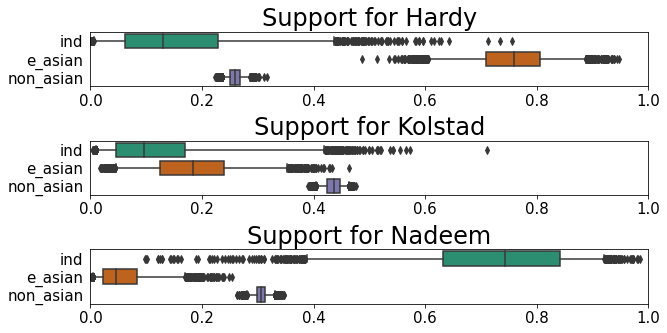

In [36]:
ax = ei.plot_boxplots()

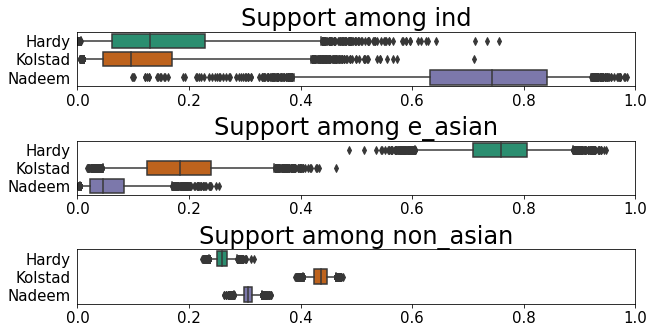

In [37]:
ax = ei.plot_boxplots(plot_by="group")

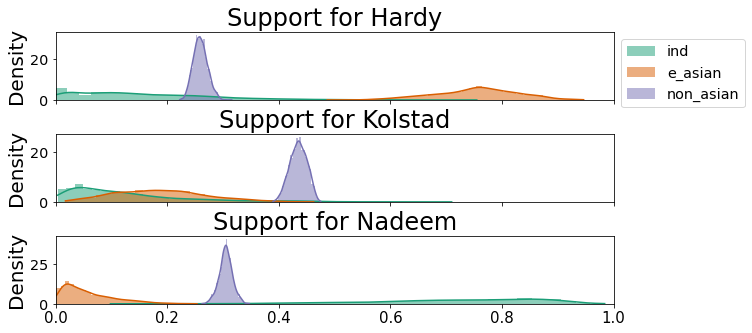

In [38]:
ax = ei.plot_kdes(plot_by="candidate")

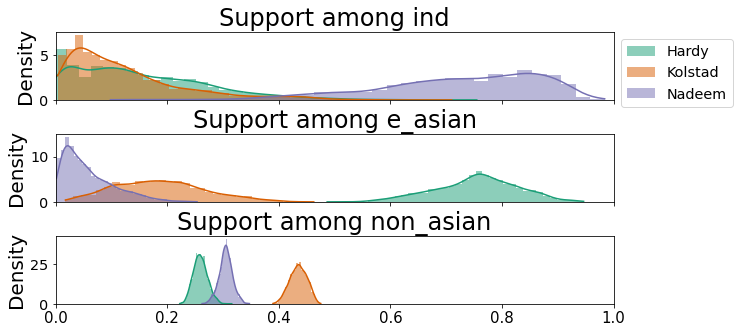

In [39]:
ax = ei.plot_kdes(plot_by="group")

<AxesSubplot:title={'center':'e_asian'}, xlabel='Support for Kolstad'>

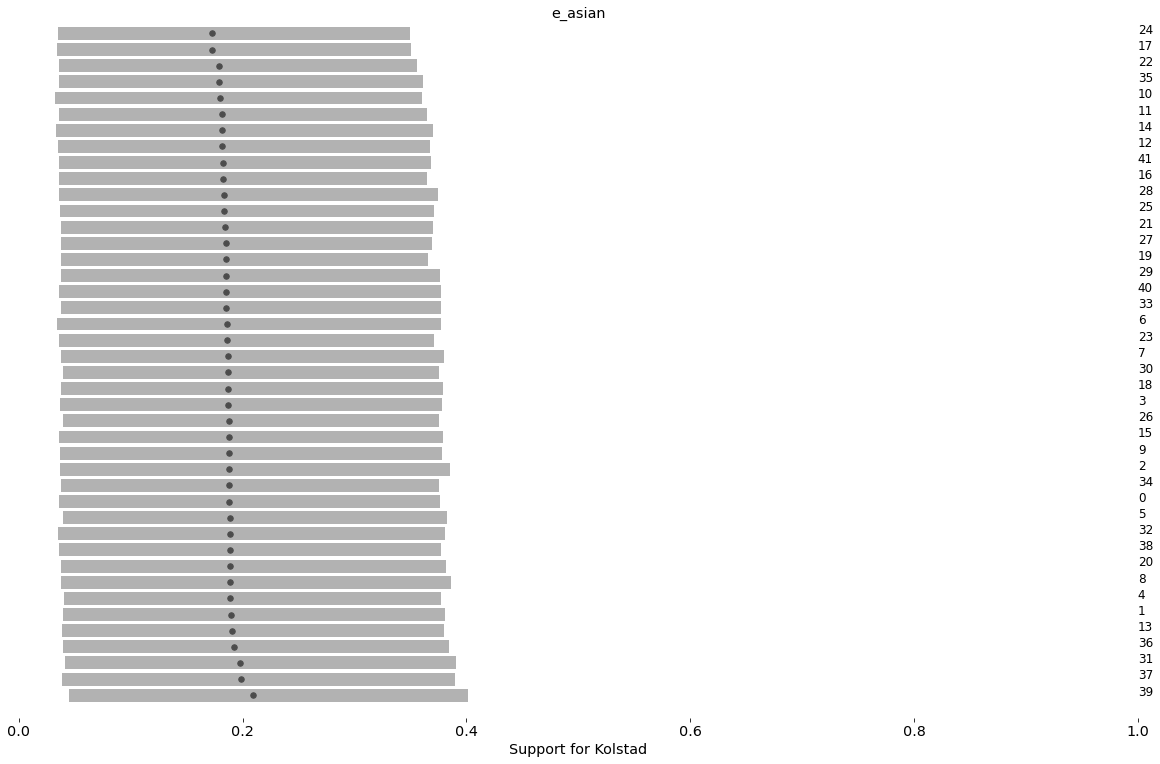

In [13]:
ei.plot_intervals_by_precinct('e_asian', 'Kolstad') # 95% credible intervals by precinct

## Polarization
### a) probability that difference is above a certain threshold

In [14]:
ei.polarization_report(["ind", "e_asian"], "Nadeem", threshold=.50)

There is a 84.2% probability that the difference between the groups' preferences for Nadeem (ind - e_asian)  is more than 0.50.


84.175

In [15]:
ei.polarization_report(["ind", "e_asian"], "Nadeem", threshold=.50, verbose=False)

84.175

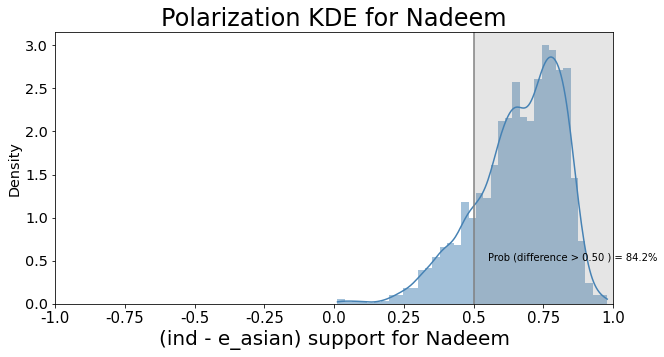

In [41]:
ax = ei.plot_polarization_kde(["ind", "e_asian"], "Nadeem", threshold=0.50, show_threshold=True)

### b) find threshold for a desired probability level

In [17]:
ei.polarization_report(["ind", "e_asian"], "Nadeem", percentile=95)

There is a 95% probability that the difference between the groups' preferences for Nadeem (ind - e_asian) is between [0.31, 0.88].


(0.31146205657144244, 0.8793736508639833)

In [18]:
ei.polarization_report(["ind", "e_asian"], "Nadeem", percentile=95, verbose=False)

(0.31146205657144244, 0.8793736508639833)

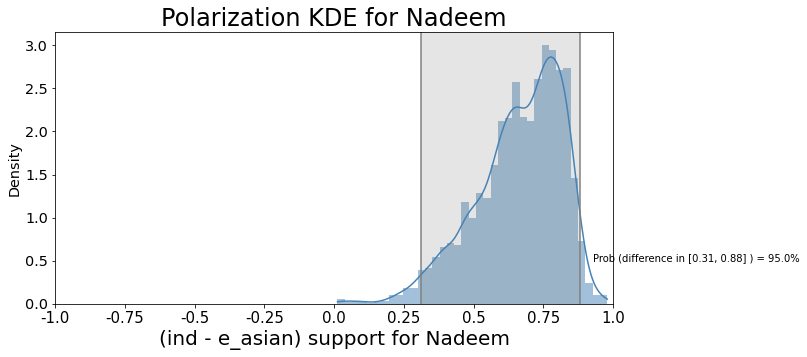

In [42]:
ax = ei.plot_polarization_kde(["ind", "e_asian"], "Nadeem", percentile=95, show_threshold=True)

### c) polarization of preferred candidates

In [20]:
ei.candidate_of_choice_polarization_report()

In 97.975 percent of samples, the district-level candidates of choice for e_asian and ind voters differ.
In 98.175 percent of samples, the district-level candidates of choice for non_asian and ind voters differ.
In 100.0 percent of samples, the district-level candidates of choice for non_asian and e_asian voters differ.


{('e_asian', 'ind'): 0.97975,
 ('ind', 'e_asian'): 0.97975,
 ('non_asian', 'ind'): 0.98175,
 ('ind', 'non_asian'): 0.98175,
 ('non_asian', 'e_asian'): 1.0,
 ('e_asian', 'non_asian'): 1.0}

In [21]:
differ_dict = ei.candidate_of_choice_polarization_report(verbose = False)
print(differ_dict[('ind','e_asian')])
print(differ_dict[('e_asian','ind')])

0.97975
0.97975


## Plotting across EI runs
Let's see how different `multinomial-dirichlet-modified` is from `multinomial-dirichlet`

In [43]:
ei_not_modified = RowByColumnEI(model_name='multinomial-dirichlet')

In [44]:
ei_not_modified.fit(group_fractions, votes_fractions, precinct_pops, demographic_group_names, candidate_names)

r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 42


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, conc_params]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [45]:
ei_runs = [ei, ei_not_modified]
run_names = ['multinomial-dirichlet-modified', 'multinomial-dirichlet']

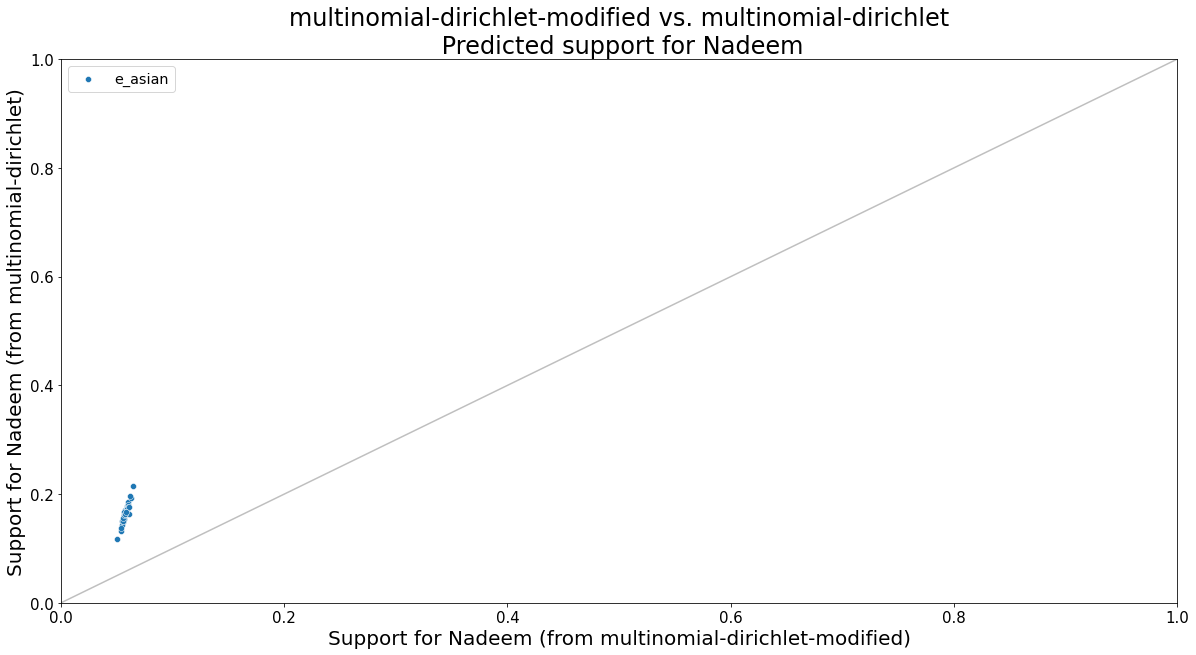

In [63]:
ax = plot_precinct_scatterplot(ei_runs, run_names, "Nadeem", "e_asian")

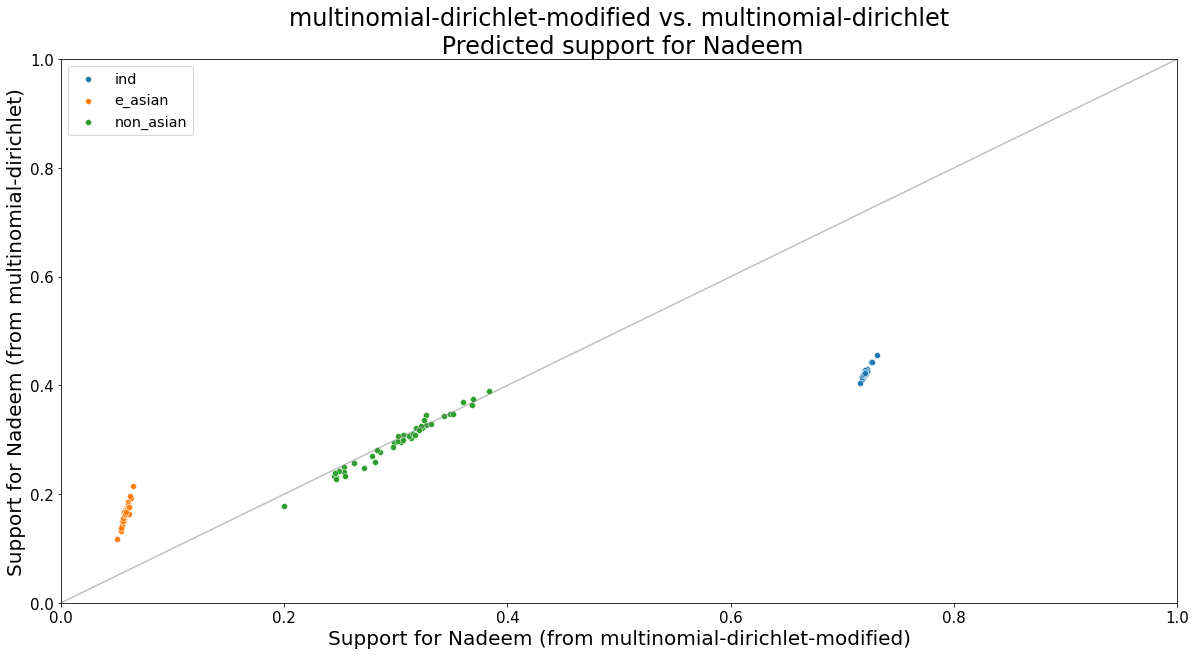

In [65]:
ax = plot_precinct_scatterplot(ei_runs, run_names, "Nadeem")

This tells us that the `multinomial-dirichlet` version seemed to overestimate Nadeem's support among East Asians and underestimate Nadeem's support among Indians, relative to the `multinomial-dirichlet-modified` version.

## Summaries
Text summaries and summary statistics

In [26]:
print(ei.summary())


            Computed from the raw b_ samples by multiplying by population and then 
            getting the proportion of the total pop 
            (total pop=summed across all districts):
            The posterior mean for the district-level voting preference of
                ind for Hardy is
                0.149
                Credible interval:  [0.0029021  0.39829176]
                The posterior mean for the district-level voting preference of
                ind for Kolstad is
                0.149
                Credible interval:  [0.01152388 0.46745764]
                The posterior mean for the district-level voting preference of
                ind for Nadeem is
                0.703
                Credible interval:  [0.38624619 0.91737667]
                The posterior mean for the district-level voting preference of
                e_asian for Hardy is
                0.774
                Credible interval:  [0.61055296 0.91401113]
                The posterior 

In [27]:
ei.candidate_of_choice_report()

ind
     - In 1.2 percent of samples, the district-level vote preference of 
       ind for Hardy was higher than for any other candidate.
     - In 3.775 percent of samples, the district-level vote preference of 
       ind for Kolstad was higher than for any other candidate.
     - In 95.025 percent of samples, the district-level vote preference of 
       ind for Nadeem was higher than for any other candidate.
e_asian
     - In 100.0 percent of samples, the district-level vote preference of 
       e_asian for Hardy was higher than for any other candidate.
     - In 0.0 percent of samples, the district-level vote preference of 
       e_asian for Kolstad was higher than for any other candidate.
     - In 0.0 percent of samples, the district-level vote preference of 
       e_asian for Nadeem was higher than for any other candidate.
non_asian
     - In 0.0 percent of samples, the district-level vote preference of 
       non_asian for Hardy was higher than for any other candidate.
  

{('ind', 'Hardy'): 0.012,
 ('ind', 'Kolstad'): 0.03775,
 ('ind', 'Nadeem'): 0.95025,
 ('e_asian', 'Hardy'): 1.0,
 ('e_asian', 'Kolstad'): 0.0,
 ('e_asian', 'Nadeem'): 0.0,
 ('non_asian', 'Hardy'): 0.0,
 ('non_asian', 'Kolstad'): 1.0,
 ('non_asian', 'Nadeem'): 0.0}

In [28]:
ei.candidate_of_choice_report(verbose = False)

{('ind', 'Hardy'): 0.012,
 ('ind', 'Kolstad'): 0.03775,
 ('ind', 'Nadeem'): 0.95025,
 ('e_asian', 'Hardy'): 1.0,
 ('e_asian', 'Kolstad'): 0.0,
 ('e_asian', 'Nadeem'): 0.0,
 ('non_asian', 'Hardy'): 0.0,
 ('non_asian', 'Kolstad'): 1.0,
 ('non_asian', 'Nadeem'): 0.0}

### Posterior means of voting preference for each group/candidate:

In [29]:
posterior_mean_voting_prefs = ei.posterior_mean_voting_prefs
df = pd.DataFrame(posterior_mean_voting_prefs, columns=candidate_names, index=demographic_group_names)
df.head()

,Hardy,Kolstad,Nadeem
ind,0.148618,0.148665,0.702717
e_asian,0.773741,0.169052,0.057207
non_asian,0.256598,0.437052,0.306350


### 95% Credible interval for voting preferences for each group:

In [30]:
num_groups, num_candidates = ei.num_groups_and_num_candidates # R, C
credible_interval_95_mean_voting_prefs = ei.credible_interval_95_mean_voting_prefs
for r in range(num_groups):
    for c in range(num_candidates):
        print(demographic_group_names[r],candidate_names[c], credible_interval_95_mean_voting_prefs[r][c])

ind Hardy [0.0029021  0.39829176]
ind Kolstad [0.01152388 0.46745764]
ind Nadeem [0.38624619 0.91737667]
e_asian Hardy [0.61055296 0.91401113]
e_asian Kolstad [0.02456158 0.32430751]
e_asian Nadeem [0.00904169 0.15047157]
non_asian Hardy [0.23277338 0.28581563]
non_asian Kolstad [0.41122927 0.46134778]
non_asian Nadeem [0.28656436 0.32554659]


### Precinct-level means and credible intervals:

In [31]:
precinct_posterior_means, precinct_credible_intervals = ei.precinct_level_estimates()
# Note: precinct_posterior_means is shape num_precincts x r x c
# Note: precinct_credible_intervals is shape num_precincts x r x c x 2 
r = 0
c= 0
print(f'Precinct support for {candidate_names[c]} among {demographic_group_names[r]}')
print(precinct_posterior_means[:,r,c])
print(f'95% credible intervals of precinct support for {candidate_names[c]} among {demographic_group_names[r]}')
print(precinct_credible_intervals[:,r,c])

Precinct support for Hardy among ind
[0.14943341 0.14959297 0.1467695  0.14877922 0.14787227 0.14798087
 0.14888823 0.14885213 0.14729639 0.14944626 0.14958592 0.14941536
 0.15122767 0.14827839 0.14900017 0.14483031 0.15009406 0.14994358
 0.14923183 0.14995279 0.15036153 0.14954932 0.14416899 0.14979921
 0.15025673 0.15038822 0.14808567 0.15178577 0.14871625 0.14805133
 0.14864288 0.14618692 0.14763955 0.14853552 0.14924614 0.15042261
 0.14857494 0.14214716 0.14820115 0.1481934  0.14907314 0.14973016]
95% credible intervals of precinct support for Hardy among ind
[[3.61639599e-04 4.18435151e-01]
 [4.08152499e-04 4.23391729e-01]
 [4.55215303e-04 4.10224005e-01]
 [4.09196985e-04 4.15747056e-01]
 [4.92691204e-04 4.18348181e-01]
 [4.65799576e-04 4.15001766e-01]
 [4.45925043e-04 4.16792087e-01]
 [6.58008618e-04 4.21625293e-01]
 [4.17955927e-04 4.15049822e-01]
 [2.42830166e-04 4.21242177e-01]
 [5.76237252e-04 4.19783341e-01]
 [4.09038322e-04 4.13826658e-01]
 [4.40506758e-04 4.26687753e-01]
 

## Samples

Samples from the posterior are accessible. 

Precinct level samples are aggregated into district level preference samples by weighting each precinct by its population:

In [32]:
ei.sampled_voting_prefs.shape # ei.sampled_voting_prefs is samples of district-level voter preference: num_samples x r x c

(4000, 3, 3)

Samples can also be obtained directly by the parameter name in the model:

In [33]:
ei.sim_trace["b"].shape # ei.sim_trace["b"] is samples of precinct-level voter preference: num_samples x num_precincts x r x c

(4000, 42, 3, 3)

Samples of hyperparameters are available:

In [34]:
ei.sim_trace["kappa"].mean(axis=0)

array([100.99861333, 101.00314876, 101.02303936])

### Accessing (and visualizing) the pymc model

In [35]:
model = ei.sim_model
pm.model_to_graphviz(model)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz